### Устанавливаем библиотеки 




Задача № 3 (для 2 курса)
 
Название: Автоматизация обработки машиночитаемых документов.
 
Описание: Вам будет выдан набор данных документов из системы документооборота небольшой вымышленной компании. На основе этого набора данных вам нужно построить граф знаний о компании, который включает:

● 	Организационную структуру (список подразделений). Есть

● 	Список сотрудников 

●  и их должностей. 

● 	Должностные обязанности и полномочия сотрудников.

На основе построенного графа знаний нужно разработать систему, которая ищет ошибки в проверочных документах (10 правильных документов, 10 документов с ошибками), например:

● 	Опечатки в названиях подразделений или ФИО сотрудников.

● 	Несуществующие подразделения или сотрудники, ошибки в должностях.

● 	Несоответствие тематики документа подразделению, в которое он направлен для исполнения (в бухгалтерию направлен документ с задачей по ИТ).
 
Ссылка на набор данных – https://www.dropbox.com/sh/d5h5f3yrql8x392/AACQ2WYa5qYCqjC8QuVZ5TJ4a?dl=1 

Вам будет передана открытая часть датасета с разметкой, закрытая часть датасета без разметки и проверочные документы (20 документов для подзадачи обнаружения ошибок в документах).
 
Требования к решению:
1.   Код программы построения графа знаний о компании (ссылка на GitHub), с помощью которого можно ответить на вопросы:
a.   Количество отделов.
b.   Количество сотрудников.
c.	К какому отделу относится конкретная задача.
2.   Код программы поиска документов с ошибками на основе графа знаний (ссылка на GitHub).
3.   Документы, в которых найдены ошибки.
 
Критерии оценки:
● 	За каждый найденный документ с ошибкой начисляется 10 баллов.
● 	За каждый документ, представленный как ошибочный, но в котором ошибки на самом деле нет, назначается штраф -1 балл.
 
Советы по реализации:
1.   Извлечь именованные сущности (NER) из текста можно с помощью библиотеки spacy (https://spacy.io/), pullenti, natasha или соответствующих моделей с huggingface (https://huggingface.co/).
2.   Для сущностей, для которых не удастся найти типовые предобученные модели (например, сущность «Задача» или «Департамент») организовать обучение модели с использованием открытой части датасета.
3.   Для построения графа связей в организации рекомендуется использовать библиотеку NetworkX - https://networkx.org/



In [120]:
#!pip install networkx
#!pip install --upgrade networkx
#!pip install pygraphviz pydot lxml
#!pip install pygraphviz
#!pytest networkx
#!pytest --pyargs networkx
#! pip install pymorphy2
#! pip install -U pip setuptools wheel
#! pip install -U spacy 
#! python -m spacy download en_core_web_sm
#! python -m spacy download ru_core_news_sm
#! pip install --user -U nltk
#! pip install -U liblinear-official
#! pip install natasha
#! pip install ipymarkup
#! pip install transformers sentencepiece sacremoses
#!pip install pymorphy2[fast]
#!pip install natasha spacy==3.3

#!python -m spacy download ru_core_news_sm
#!pip install tensorflow-text spacy==3.3
#!python -m spacy download ru_core_news_sm
#!pip install pymorphy2[fast] 


In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from yargy.tokenizer import MorphTokenizer
from yargy import rule, or_, Parser
from yargy.predicates import eq, type as _t, normalized, gram
from ipymarkup import show_span_box_markup, show_span_line_markup
from yargy.pipelines import morph_pipeline as mp, caseless_pipeline as cp
from yargy.interpretation import fact
from IPython.display import display

from transformers import pipeline, AutoTokenizer, AutoConfig, AutoModelForTokenClassification

# Морфологический анализ
import pymorphy2

# Синтаксический анализ
import spacy
from spacy import displacy

import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
import gensim.models


import requests
import nltk
import spacy
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2

import spacy
from spacy import displacy

2023-01-20 18:57:39.718210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open('merged_data.json', "r") as readFile:
            merge_data = json.load(readFile)

In [276]:
text = []
for n in range(10):
    a = merge_data[n]['Tasks']['Task1']['task_responsibles_people']
    text.append(a)

text  


['Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.',
 'Ответственность за исполнение распоряжения возложить на специалиста третьей категории Службы ИТ Кима Юрия Ивановича',
 'Контроль над исполнением распоряжения оставить за тимлидами проектной команды Абаимовым Симоном',
 'Контроль над выполнением настоящего распоряжения оставляю за собой',
 'Контроль над выполнением настоящего распоряжения оставляю за собой',
 'Контроль над выполнением приказа возложить на руководителя отдела проектирования Департамента разработки Шихова Р.П.',
 'Обеспечение выполнения возложить на специалиста второй категории бухгалтерии Смирнову О.А.',
 'За контроль и выполнение назначить ответственным специалиста третьей категории отдела разработки систем Андреева С.Е.',
 'За контроль над исполнением распоряжения назначить ответственным специалиста второй категории отдела разработки пользовательских интерфейсов Попова А.А.',
 '

### Определяем количество департаментов в компании

In [4]:
departments = []
for n in range(10000):
    departments.append(merge_data[n]['Tasks']['Task1']['task_responsibles_groups'])



In [278]:
FIO = []
for n in range(10000):
    FIO.append(merge_data[n]['Tasks']['Task1']['task_responsibles_people'])

In [284]:
1 departments[:1],2 FIO[:1],3 POSITION[:1] FUCNTIONAL [] [][ [] [ ] [] y = natahsa [семёнову ]
1 departments[:1],2 FIO[:1],3 POSITION[:1]  y = natahsa [Иванов  ] 
... 
10000 

pd_read_docx = >> документ = Иванова 


(['Административно-хозяйственный отдел'],
 ['Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.'],
 [['Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.']])

In [6]:
merge_data[2]['Tasks']['Global_supervisor']

['Контроль над исполнением распоряжения оставить за тимлидами проектной команды Абаимовым Симоном',
 'Ответственным за исполнение настоящего приказа назначить тимлид проектной команды Абаимова Симона',
 'За контроль над исполнением распоряжения назначить ответственным программиста Абашкина Ореста',
 'Ответственным за контролем над исполнением вышеизложенных задач назначить технического писателя Абалкина Зураба',
 'Контроль над исполнением распоряжения оставить за специалистом третьей категории отдела разработки пользовательских интерфейсов Андреевым С.Е.',
 'За контроль и выполнение назначить ответственным специалиста третьей категории отдела разработки систем Андреева С.Е.']

In [277]:
POSITION = []
for n in range(10000):
    try:
        POSITION.append(merge_data[n]['Tasks']['Global_supervisor'])
    except KeyError:
        continue

In [ ]:
POSITION[]

In [8]:
text = POSITION[40:55]
text

[['Контроль над выполнением приказа возложить на специалиста третьей категории Службы ИТ Кима Юрия Ивановича',
  'Ответственность за исполнение распоряжения возложить на системного администратора Сергеева Андрея'],
 ['За контроль над исполнением распоряжения назначить ответственным системного администратора Сергеева Андрея',
  'За контроль над исполнением распоряжения назначить ответственным мастера по ремонту компьютеров Абалакина Михаила',
  'Ответственным за контролем над исполнением вышеизложенных задач назначить системного администратора Абалакова Севастьяна',
  'Контроль над исполнением распоряжения оставить за руководителем Службы ИТ: Р.Е.Артюхиным',
  'За контроль и выполнение назначить ответственным специалиста третьей категории Службы ИТ Кима Юрия Ивановича'],
 ['Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.'],
 ['Контроль над исполнением распоряжения оставить за специалистом первой кат

### Очищаем данные

In [9]:
def text_split(text: str):
    pouch_of_words = []
    for line in text:
        line = " ".join(line)
        line = line.split()
        pouch_of_words.append(line)
    return pouch_of_words

In [10]:
def token_words_split(text: str):
    pouch_of_words = []
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            TOKENIZER = word_tokenize(line)
            pouch_of_words.append(TOKENIZER)
    return pouch_of_words

pouch_of_words = token_words_split(POSITION)

In [101]:
#def token_tf_text_split(text: str):
#    pouch_of_words = []
#    if type(text) == list:
#        for line in text:
#            line = " ".join(line) 
#            sp_model = line
#            tokenizer = tf_text.SentencepieceTokenizer(sp_model, out_type=tf.string)
#            tokens = tokenizer.tokenize([line])
#            pouch_of_words.append([token.decode('utf-8') for token in tokens.to_list()[0]])
#    return pouch_of_words

#token_tf_text_split(POSITION[:10])

In [11]:
text = POSITION[:2]

def split_spacy(text: str):
    pouch_of_words = []
    nlp = spacy.load('ru_core_news_sm')
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            doc = nlp(line)
            for token in doc:
                pouch_of_words.append(token)
    return pouch_of_words


In [12]:
def sentence(text: str):
    nltk.download('punkt')
    sentences = sent_tokenize(text)
    return sentences


### Морфологический анализ

In [13]:
morph = pymorphy2.MorphAnalyzer()

In [14]:
def morph_word(words: str):
    words = split_spacy(words)
    morph_words = []
    for word in words:
        try:
            for n in range(len(pouch_of_words[0])):
                           morph_words.append(morph.parse(pouch_of_words[n][n]))
        except KeyError:
                       continue
    return morph_words


### Синтаксический анализ

In [15]:
nlp_synt = spacy.load('ru_core_news_sm')

### Разделяем текст на предложения.

In [16]:
text = POSITION[:5]
text

[['Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.'],
 ['Ответственность за исполнение распоряжения возложить на специалиста третьей категории Службы ИТ Кима Юрия Ивановича',
  'Контроль над выполнением приказа возложить на системного администратора Сергеева Андрея',
  'Контроль над исполнением распоряжения оставить за специалистом третьей категории Службы ИТ Кимом Юрием Ивановичем'],
 ['Контроль над исполнением распоряжения оставить за тимлидами проектной команды Абаимовым Симоном',
  'Ответственным за исполнение настоящего приказа назначить тимлид проектной команды Абаимова Симона',
  'За контроль над исполнением распоряжения назначить ответственным программиста Абашкина Ореста',
  'Ответственным за контролем над исполнением вышеизложенных задач назначить технического писателя Абалкина Зураба',
  'Контроль над исполнением распоряжения оставить за специалистом третьей категории отдела разработки п

In [17]:
def sentence(text: str):
    pouch_of_sentence = []
    if type(text) == list:
        for line in text:
            line = " ".join(line)
            nltk.download('punkt')
            sentences = sent_tokenize(line)
            pouch_of_sentence.append(sentences)
    return str(pouch_of_sentence)
    
text = sentence(POSITION[10:12])

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [155]:
text

"[['Ответственность за исполнение распоряжения возложить на специалиста третьей категории Службы ИТ Кима Юрия Ивановича Контроль над выполнением приказа возложить на системного администратора Сергеева Андрея Контроль над исполнением распоряжения оставить за специалистом третьей категории Службы ИТ Кимом Юрием Ивановичем'], ['Ответственность за исполнение распоряжения возложить на специалиста третьей категории Службы ИТ Кима Юрия Ивановича Контроль над выполнением приказа возложить на системного администратора Сергеева Андрея Контроль над исполнением распоряжения оставить за специалистом третьей категории Службы ИТ Кимом Юрием Ивановичем']]"

In [18]:
doc = nlp_synt(text)

In [19]:
for token in doc:
    print(token.text, token.pos_, token.dep_)

[ PUNCT punct
[ PUNCT punct
' PUNCT punct
Ответственным ADJ xcomp
за ADP case
контролем NOUN obl
над ADP case
исполнением NOUN nmod
вышеизложенных ADJ amod
задач NOUN nmod
назначить VERB nmod
специалиста NOUN obj
второй ADJ amod
категории NOUN nmod
отдела NOUN nmod
проектирования NOUN nmod
Попова PROPN nmod
И.И. PROPN flat:name
' PUNCT punct
, PUNCT punct
' PUNCT punct
Контроль NOUN appos
над ADP case
исполнением NOUN nmod
распоряжения NOUN nmod
оставить VERB nmod
за ADP case
специалистом NOUN obl
первой ADJ amod
категории NOUN nmod
отдела NOUN nmod
проектирования NOUN nmod
Семеновым PROPN appos
И.А. PROPN flat:name
' PUNCT punct
, PUNCT punct
' PUNCT punct
Контроль NOUN conj
над ADP case
выполнением NOUN nmod
настоящего ADJ amod
приказа NOUN nmod
возложить VERB nmod
на ADP case
руководителя NOUN obl
отдела NOUN nmod
проектирования NOUN nmod
Департамента PROPN nmod
разработки NOUN nmod
Шихова PROPN nmod
Р.П. PROPN flat:name
' PUNCT punct
, PUNCT punct
' PUNCT punct
Контроль NOUN nsubj


In [20]:
displacy.render(doc, style="dep", jupyter=True)

In [159]:
### Использование библиоетки natasha

In [21]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
 
    Doc
)


In [22]:
 
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [23]:
syntax_parser = NewsSyntaxParser(emb)


In [24]:
text

"[['Ответственным за контролем над исполнением вышеизложенных задач назначить специалиста второй категории отдела проектирования Попова И.И.', 'Контроль над исполнением распоряжения оставить за специалистом первой категории отдела проектирования Семеновым И.А.', 'Контроль над выполнением настоящего приказа возложить на руководителя отдела проектирования Департамента разработки Шихова Р.П.', 'Контроль над выполнением настоящего распоряжения оставляю за собой Контроль над выполнением настоящего распоряжения оставляю за собой Контроль над исполнением распоряжения оставить за руководителем отдела проектирования Департамента разработки Шиховым Р.П.', 'За контроль над исполнением распоряжения назначить ответственным специалиста третьей категории отдела проектирования Коптелова Е.В'], ['Ответственным за контролем над исполнением вышеизложенных задач назначить специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.', 'Ответственным за исполнение настоящего приказа назн

In [25]:
doc_n = Doc(text)

In [26]:
doc_n.segment(segmenter)


In [27]:
for tocken in doc_n.tokens:
    print(tocken)

DocToken(stop=1, text='[')
DocToken(start=1, stop=2, text='[')
DocToken(start=2, stop=3, text="'")
DocToken(start=3, stop=16, text='Ответственным')
DocToken(start=17, stop=19, text='за')
DocToken(start=20, stop=29, text='контролем')
DocToken(start=30, stop=33, text='над')
DocToken(start=34, stop=45, text='исполнением')
DocToken(start=46, stop=60, text='вышеизложенных')
DocToken(start=61, stop=66, text='задач')
DocToken(start=67, stop=76, text='назначить')
DocToken(start=77, stop=88, text='специалиста')
DocToken(start=89, stop=95, text='второй')
DocToken(start=96, stop=105, text='категории')
DocToken(start=106, stop=112, text='отдела')
DocToken(start=113, stop=127, text='проектирования')
DocToken(start=128, stop=134, text='Попова')
DocToken(start=135, stop=136, text='И')
DocToken(start=136, stop=137, text='.')
DocToken(start=137, stop=138, text='И')
DocToken(start=138, stop=139, text='.')
DocToken(start=139, stop=140, text="'")
DocToken(start=140, stop=141, text=',')
DocToken(start=142,

In [28]:
doc_n.parse_syntax(syntax_parser)

In [29]:
for tocken in doc_n.tokens:
    print(tocken)

DocToken(stop=1, text='[', id='1_1', head_id='1_77', rel='punct')
DocToken(start=1, stop=2, text='[', id='1_2', head_id='1_77', rel='punct')
DocToken(start=2, stop=3, text="'", id='1_3', head_id='1_4', rel='punct')
DocToken(start=3, stop=16, text='Ответственным', id='1_4', head_id='1_150', rel='appos')
DocToken(start=17, stop=19, text='за', id='1_5', head_id='1_122', rel='case')
DocToken(start=20, stop=29, text='контролем', id='1_6', head_id='1_77', rel='obl')
DocToken(start=30, stop=33, text='над', id='1_7', head_id='1_191', rel='case')
DocToken(start=34, stop=45, text='исполнением', id='1_8', head_id='1_189', rel='nmod')
DocToken(start=46, stop=60, text='вышеизложенных', id='1_9', head_id='1_161', rel='amod')
DocToken(start=61, stop=66, text='задач', id='1_10', head_id='1_74', rel='nmod')
DocToken(start=67, stop=76, text='назначить', id='1_11', head_id='1_104', rel='xcomp')
DocToken(start=77, stop=88, text='специалиста', id='1_12', head_id='1_84', rel='obj')
DocToken(start=89, stop=9

In [30]:
doc_n.sents[0].syntax.print()

                                                                                                                          ┌────────────────────────────────────────────────────────────────────────────────────────► [                              punct
                                                                                                                          │ ┌──────────────────────────────────────────────────────────────────────────────────────► [                              punct
                                                                                                                          │ │                                                                                     ┌► '                              punct
┌─┌─┌───────────────┌──────────────────────────────────►┌───┌───────┌───┌─────────────────────┌───────────────────────────│ │                           ┌─────────────────────────────────┌─────────────────────┌─└─ Ответственным                  appos


### Выявление ФИО

In [31]:
FIO = []

for tocken in doc_n.tokens:
    if tocken.rel == 'flat:name' or tocken.rel == 'appos':
        if tocken.rel == 'appos':
            surn = tocken.text 
            if surn in FIO:
                pass
            else:
                FIO.append(surn)
        elif tocken.rel == 'flat:name':
            IO = tocken.text + '.'      
            FIO.append(IO)
           
FIO

['Ответственным',
 'И.',
 'И.',
 'Семеновым',
 'И.',
 'А.',
 'Шихова',
 'Р.',
 'П.',
 'Шиховым',
 'Р.',
 'П.',
 'Коптелова',
 'Е.',
 'Кравцову',
 'И.',
 'Е.',
 'С.',
 'Галкина.',
 'Сергееву',
 'Алену.',
 'Ивановну.',
 'Ответственным.',
 'С.',
 'Галкина.',
 'И.',
 'Е.',
 'Алену',
 'Ивановну.']

In [32]:
doc_n.segment(segmenter) 
doc_n.tag_morph(morph_tagger)
doc_n.parse_syntax(syntax_parser)
doc_n.tag_ner(ner_tagger)

In [33]:
display(doc_n.tokens[:5])

[DocToken(stop=1, text='[', id='1_1', head_id='1_77', rel='punct', pos='PUNCT'),
 DocToken(start=1, stop=2, text='[', id='1_2', head_id='1_77', rel='punct', pos='PUNCT'),
 DocToken(start=2, stop=3, text="'", id='1_3', head_id='1_4', rel='punct', pos='PUNCT'),
 DocToken(start=3, stop=16, text='Ответственным', id='1_4', head_id='1_150', rel='appos', pos='ADJ', feats=<Ins,Pos,Masc,Sing>),
 DocToken(start=17, stop=19, text='за', id='1_5', head_id='1_122', rel='case', pos='ADP')]

In [34]:
display(doc_n.sents)

[DocSent(stop=1667, text="[['Ответственным за контролем над исполнением выш..., tokens=[...], spans=[...])]

In [35]:
doc_n.tag_morph(morph_tagger)
display(doc_n.tokens)

[DocToken(stop=1, text='[', id='1_1', head_id='1_77', rel='punct', pos='PUNCT'),
 DocToken(start=1, stop=2, text='[', id='1_2', head_id='1_77', rel='punct', pos='PUNCT'),
 DocToken(start=2, stop=3, text="'", id='1_3', head_id='1_4', rel='punct', pos='PUNCT'),
 DocToken(start=3, stop=16, text='Ответственным', id='1_4', head_id='1_150', rel='appos', pos='ADJ', feats=<Ins,Pos,Masc,Sing>),
 DocToken(start=17, stop=19, text='за', id='1_5', head_id='1_122', rel='case', pos='ADP'),
 DocToken(start=20, stop=29, text='контролем', id='1_6', head_id='1_77', rel='obl', pos='NOUN', feats=<Inan,Ins,Masc,Sing>),
 DocToken(start=30, stop=33, text='над', id='1_7', head_id='1_191', rel='case', pos='ADP'),
 DocToken(start=34, stop=45, text='исполнением', id='1_8', head_id='1_189', rel='nmod', pos='NOUN', feats=<Inan,Ins,Neut,Sing>),
 DocToken(start=46, stop=60, text='вышеизложенных', id='1_9', head_id='1_161', rel='amod', pos='ADJ', feats=<Gen,Pos,Plur>),
 DocToken(start=61, stop=66, text='задач', id='1_

In [36]:
for span in doc_n.spans:
    span.normalize(morph_vocab)

{_.text: _.normal for _ in doc_n.spans if _.text != _.normal}

{'Попова И.И.': 'Попов И.И.',
 'Семеновым И.А.': 'Семенов И.А.',
 'Департамента разработки': 'Департамент разработка',
 'Шихова Р.П.': 'Шихов Р.П.',
 "Коптелова Е.В']": "Коптелов Е.В']",
 'Кравцову И.Е.': 'Кравцов И.Е.',
 'Административно-хозяйственного отдела': 'Административно-хозяйственный отдел',
 'С.С.Галкина': 'С.С.Галкин',
 'Сергееву Алену Ивановну Ответственным': 'Сергеев Алена Ивановна Ответственным',
 'Сергееву Алену Ивановну': 'Сергеев Алена Ивановну'}

In [37]:
for token in doc_n.tokens:
    token.lemmatize(morph_vocab)
    
{_.text: _.lemma for _ in doc_n.tokens}

{'[': '[',
 "'": "'",
 'Ответственным': 'ответственный',
 'за': 'за',
 'контролем': 'контроль',
 'над': 'над',
 'исполнением': 'исполнение',
 'вышеизложенных': 'вышеизложенный',
 'задач': 'задача',
 'назначить': 'назначить',
 'специалиста': 'специалист',
 'второй': 'второй',
 'категории': 'категория',
 'отдела': 'отдел',
 'проектирования': 'проектирование',
 'Попова': 'попов',
 'И': 'и',
 '.': '.',
 ',': ',',
 'Контроль': 'контроль',
 'распоряжения': 'распоряжение',
 'оставить': 'оставить',
 'специалистом': 'специалист',
 'первой': 'первый',
 'Семеновым': 'семенов',
 'А': 'а',
 'выполнением': 'выполнение',
 'настоящего': 'настоящий',
 'приказа': 'приказ',
 'возложить': 'возложить',
 'на': 'на',
 'руководителя': 'руководитель',
 'Департамента': 'департамент',
 'разработки': 'разработка',
 'Шихова': 'шихов',
 'Р': 'р',
 'П': 'п',
 'оставляю': 'оставлять',
 'собой': 'себя',
 'руководителем': 'руководитель',
 'Шиховым': 'шихов',
 'За': 'за',
 'контроль': 'контроль',
 'ответственным': 'отве

### Создание дата фрейма и векторизация слов.

In [38]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
POSITION[:2]  [0,3,403,5]

[['Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.'],
 ['Ответственность за исполнение распоряжения возложить на специалиста третьей категории Службы ИТ Кима Юрия Ивановича',
  'Контроль над выполнением приказа возложить на системного администратора Сергеева Андрея',
  'Контроль над исполнением распоряжения оставить за специалистом третьей категории Службы ИТ Кимом Юрием Ивановичем']]

In [40]:
data = POSITION
data
df = pd.DataFrame(data, columns = ['Задача','Задача_2','Задача_3','Задача_4','Задача_5','Задача_6','Задача_7','Задача_8','Задача_9'])

In [275]:
df

,Задача,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9
0,Ответственность за исполнение распоряжения воз...,0,0,0,0,0,0,0,0
1,Ответственность за исполнение распоряжения воз...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,0,0,0,0,0,0
2,Контроль над исполнением распоряжения оставить...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,0,0,0
3,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на специалист...,Контроль над выполнением настоящего распоряжен...,Ответственным за контролем над исполнением выш...,Ответственным за исполнение настоящего приказа...,0,0,0,0
4,Контроль над выполнением настоящего распоряжен...,Ответственным за исполнение настоящего приказа...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9995,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,0,0,0,0,0,0,0
9996,Контроль над исполнением распоряжения оставить...,Ответственным за контролем над исполнением выш...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего распоряжен...,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на мастера по...,За контроль над исполнением распоряжения назна...,Контроль над выполнением настоящего распоряжен...
9997,Контроль над выполнением настоящего распоряжен...,Ответственность за исполнение распоряжения воз...,Контроль над исполнением распоряжения оставить...,Обеспечение выполнения возложить на специалист...,Ответственность за исполнение распоряжения воз...,0,0,0,0
9998,Обеспечение выполнения возложить на специалист...,За контроль над исполнением распоряжения назна...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,Контроль над исполнением распоряжения оставить...,Обеспечение выполнения возложить на руководите...,Ответственность за исполнение распоряжения воз...,0,0


In [62]:
text = df.iloc[:]
text

,Задача,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9
0,Ответственность за исполнение распоряжения воз...,0,0,0,0,0,0,0,0
1,Ответственность за исполнение распоряжения воз...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,0,0,0,0,0,0
2,Контроль над исполнением распоряжения оставить...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,0,0,0
3,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на специалист...,Контроль над выполнением настоящего распоряжен...,Ответственным за контролем над исполнением выш...,Ответственным за исполнение настоящего приказа...,0,0,0,0
4,Контроль над выполнением настоящего распоряжен...,Ответственным за исполнение настоящего приказа...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9995,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,0,0,0,0,0,0,0
9996,Контроль над исполнением распоряжения оставить...,Ответственным за контролем над исполнением выш...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего распоряжен...,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на мастера по...,За контроль над исполнением распоряжения назна...,Контроль над выполнением настоящего распоряжен...
9997,Контроль над выполнением настоящего распоряжен...,Ответственность за исполнение распоряжения воз...,Контроль над исполнением распоряжения оставить...,Обеспечение выполнения возложить на специалист...,Ответственность за исполнение распоряжения воз...,0,0,0,0
9998,Обеспечение выполнения возложить на специалист...,За контроль над исполнением распоряжения назна...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,Контроль над исполнением распоряжения оставить...,Обеспечение выполнения возложить на руководите...,Ответственность за исполнение распоряжения воз...,0,0


In [ ]:
tokens = word_tokenize(text.lower())


AttributeError: 'DataFrame' object has no attribute 'lower'

In [44]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '..', '...',' ','"',"'",'`','``','"""',"''",'i','ii','iii','[',']']

/Users/macbook/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/IPython/core/inputtransformer2.py:595: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  tokens_by_line = make_tokens_by_line(lines)


In [45]:
words = []
for token in tokens:
    if token not in punctuation_marks:
        words.append(token)
        
words

['ответственность',
 'за',
 'исполнение',
 'распоряжения',
 'возложить',
 'на',
 'специалиста',
 'третьей',
 'категории',
 'службы',
 'ит',
 'кима',
 'юрия',
 'ивановича']

In [46]:
morph = pymorphy2.MorphAnalyzer()

In [47]:
lemmas = []
for token in words:
    lemmas.append(morph.parse(token)[0].normal_form)

In [48]:
stop_words = stopwords.words("russian")

In [49]:
clean_words = []
for token in lemmas:
    if token not in stop_words:
        clean_words.append(token)

In [50]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [64]:
preprocess(text, stop_words, punctuation_marks, morph)


AttributeError: 'DataFrame' object has no attribute 'lower'

In [52]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '..', '...',' ','"',"'",'`','``','"""',"''",'i','ii','iii','[',']']
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [53]:
df_test = df[1:3]
df_test

,Задача,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9
1,Ответственность за исполнение распоряжения воз...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,None,None,None,None,None,None
2,Контроль над исполнением распоряжения оставить...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,None,None,None


In [55]:
df = df.fillna(value=0)
df

,Задача,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9
0,Ответственность за исполнение распоряжения воз...,0,0,0,0,0,0,0,0
1,Ответственность за исполнение распоряжения воз...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,0,0,0,0,0,0
2,Контроль над исполнением распоряжения оставить...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,0,0,0
3,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на специалист...,Контроль над выполнением настоящего распоряжен...,Ответственным за контролем над исполнением выш...,Ответственным за исполнение настоящего приказа...,0,0,0,0
4,Контроль над выполнением настоящего распоряжен...,Ответственным за исполнение настоящего приказа...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9995,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,0,0,0,0,0,0,0
9996,Контроль над исполнением распоряжения оставить...,Ответственным за контролем над исполнением выш...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего распоряжен...,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на мастера по...,За контроль над исполнением распоряжения назна...,Контроль над выполнением настоящего распоряжен...
9997,Контроль над выполнением настоящего распоряжен...,Ответственность за исполнение распоряжения воз...,Контроль над исполнением распоряжения оставить...,Обеспечение выполнения возложить на специалист...,Ответственность за исполнение распоряжения воз...,0,0,0,0
9998,Обеспечение выполнения возложить на специалист...,За контроль над исполнением распоряжения назна...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,Контроль над исполнением распоряжения оставить...,Обеспечение выполнения возложить на руководите...,Ответственность за исполнение распоряжения воз...,0,0


In [423]:
list_col = df_test.columns
for col in list_col:
    print(col)

Задача
Задача_2
Задача_3
Задача_4
Задача_5
Задача_6
Задача_7
Задача_8
Задача_9


In [156]:
df_test

,Задача,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9
1,Ответственность за исполнение распоряжения воз...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,None,None,None,None,None,None
2,Контроль над исполнением распоряжения оставить...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,None,None,None


In [158]:
df_new = df.apply(lambda row: preprocess(row['Задача'], punctuation_marks, stop_words, morph), axis=1)
df_new

0       [ответственность, исполнение, распоряжение, во...
1       [ответственность, исполнение, распоряжение, во...
2       [контроль, исполнение, распоряжение, оставить,...
3       [контроль, выполнение, настоящий, распоряжение...
4       [контроль, выполнение, настоящий, распоряжение...
                              ...                        
9995    [ответственный, исполнение, настоящий, приказ,...
9996    [контроль, исполнение, распоряжение, оставить,...
9997    [контроль, выполнение, настоящий, распоряжение...
9998    [обеспечение, выполнение, возложить, специалис...
9999    [ответственность, исполнение, распоряжение, во...
Length: 10000, dtype: object

In [160]:
for name, values in df.iteritems():
    print(name, values)

Задача 0       Ответственность за исполнение распоряжения воз...
1       Ответственность за исполнение распоряжения воз...
2       Контроль над исполнением распоряжения оставить...
3       Контроль над выполнением настоящего распоряжен...
4       Контроль над выполнением настоящего распоряжен...
                              ...                        
9995    Ответственным за исполнение настоящего приказа...
9996    Контроль над исполнением распоряжения оставить...
9997    Контроль над выполнением настоящего распоряжен...
9998    Обеспечение выполнения возложить на специалист...
9999    Ответственность за исполнение распоряжения воз...
Name: Задача, Length: 10000, dtype: object
Задача_2 0                                                       0
1       Контроль над выполнением приказа возложить на ...
2       Ответственным за исполнение настоящего приказа...
3       Обеспечение выполнения возложить на специалист...
4       Ответственным за исполнение настоящего приказа...
             

In [162]:
def iter_items(data):
    lemma = []
    for _, values in data.iteritems():
        for j in values:

            lemma.append(j)
    print(lemma)

print(iter_items(df))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [184]:
for data in df.items():
        print(type(data[:]))
        #print(preprocess(data, punctuation_marks, stop_words, morph))


<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


In [201]:
df.iat[0,0]

'Ответственность за исполнение распоряжения возложить на специалиста первой категории административно-хозяйственного отдела Кравцову И.Е.'

In [263]:
from gensim.test.utils import common_texts

from gensim.models import Word2Vec

In [242]:
df_new = pd.DataFrame()
words_df = []
for n in range(len(df)):
    for i in df:
        try:
            data = preprocess(df.iat[n,n], punctuation_marks, stop_words, morph)
            #print(data)
            #df_new = pd.concat([df_new, data], axis = 1)
            words_df.append(data)
        except: 
            continue


In [247]:
df_new = pd.DataFrame(words_df)
df_new_com = pd.concat([df, df_new], axis = 1)
df_new_com = df_new_com.fillna(0)


In [269]:
common_texts = df_new_com.loc[:,0:]

In [ ]:
 нейсеть: n - классов : Иванов1  сидовров 2 
json : natahsa >> Иванова Сидоров >> векторизует >> модель на основе векторов [0, 0, 1] 


In [ ]:
doc >> нейросеть >> классификация: документ правильный/не правильный : адресован: Иванову


In [270]:
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)

TypeError: 'int' object is not iterable

In [267]:
model.save("word2vec.model")

In [71]:
def clean_df(df):
    list_col = df_test.columns
    for col in list_col:
        try:
            print(col)
            df_new = df.apply(lambda row: preprocess(row[col], punctuation_marks, stop_words, morph), axis=1)
            print(row[col])
            print(df_new)
        except AttributeError:
            continue
        return df_new

        
clean_df(df_test)

Задача


NameError: name 'row' is not defined

1    [ответственность, исполнение, распоряжение, во...
2    [контроль, исполнение, распоряжение, оставить,...
dtype: object

In [80]:
#df_new = df.apply(lambda row: preprocess(row['Задача'], punctuation_marks, stop_words, morph), axis=1)
df_new

0       [ответственность, исполнение, распоряжение, во...
1       [ответственность, исполнение, распоряжение, во...
2       [контроль, исполнение, распоряжение, оставить,...
3       [контроль, выполнение, настоящий, распоряжение...
4       [контроль, выполнение, настоящий, распоряжение...
                              ...                        
9995    [ответственный, исполнение, настоящий, приказ,...
9996    [контроль, исполнение, распоряжение, оставить,...
9997    [контроль, выполнение, настоящий, распоряжение...
9998    [обеспечение, выполнение, возложить, специалис...
9999    [ответственность, исполнение, распоряжение, во...
Length: 10000, dtype: object

### Частотность слов

In [81]:
from collections import Counter

In [125]:
test_counter = Counter(df_con[0][0])
test_counter

Counter({'ответственность': 1,
         'исполнение': 1,
         'распоряжение': 1,
         'возложить': 1,
         'специалист': 1,
         'первый': 1,
         'категория': 1,
         'административно-хозяйственный': 1,
         'отдел': 1,
         'кравцов': 1,
         'и.е': 1,
         '.': 1})

In [126]:
test_counter.most_common(10)

[('ответственность', 1),
 ('исполнение', 1),
 ('распоряжение', 1),
 ('возложить', 1),
 ('специалист', 1),
 ('первый', 1),
 ('категория', 1),
 ('административно-хозяйственный', 1),
 ('отдел', 1),
 ('кравцов', 1)]

In [127]:
words_ = Counter()

In [128]:
for txt in df_con[0]:
    words.update(txt)

In [129]:
len(words)

142

In [130]:
words.most_common(10)

[('контроль', 13916),
 ('специалист', 10934),
 ('категория', 10934),
 ('.', 10072),
 ('выполнение', 10018),
 ('исполнение', 9982),
 ('отдел', 9058),
 ('распоряжение', 8034),
 ('возложить', 7974),
 ('назначить', 7956)]

In [131]:
# Словарь, отображающий слова в коды
word_to_index = dict()
# Словарь, отображающий коды в слова
index_to_word = dict()

In [101]:
max_words = 10000

In [102]:
for i, word in enumerate(words.most_common(max_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

In [104]:
word_to_index

In [105]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1) # 1 означает неизвестное слово
        # Неизвестные слова не добавляем в выходную последовательность
        if index != 1:
            seq.append(index)
    return seq



In [110]:
txt = df_con[0][0]

In [111]:
seq = text_to_sequence(txt, word_to_index)

In [112]:
seq

[25, 7, 9, 10, 3, 15, 4, 16, 8, 46, 47, 5]

In [113]:
index_to_word[43]

'тестирование'

In [114]:
seq = [word_to_index.get(word, 1) for word in txt]

In [115]:
seq

[25, 7, 9, 10, 3, 15, 4, 16, 8, 46, 47, 5]

In [116]:
df_con_int = df_con.apply(lambda row: text_to_sequence(row[0], word_to_index), axis=1)

In [155]:
#df_con_int = pd.concat([df_con, df_con_int], axis = 1)
df_con_int[0]

,0,0,0
0,"[ответственность, исполнение, распоряжение, во...","[ответственность, исполнение, распоряжение, во...","[25, 7, 9, 10, 3, 15, 4, 16, 8, 46, 47, 5]"
1,"[ответственность, исполнение, распоряжение, во...","[ответственность, исполнение, распоряжение, во...","[25, 7, 9, 10, 3, 28, 4, 31, 32, 86, 87, 30]"
2,"[контроль, исполнение, распоряжение, оставить,...","[контроль, исполнение, распоряжение, оставить,...","[2, 7, 9, 24, 95, 96, 97, 98, 139]"
3,"[контроль, выполнение, настоящий, распоряжение...","[контроль, выполнение, настоящий, распоряжение...","[2, 6, 13, 9, 22, 23]"
4,"[контроль, выполнение, настоящий, распоряжение...","[контроль, выполнение, настоящий, распоряжение...","[2, 6, 13, 9, 22, 23]"
...,...,...,...
9995,"[ответственный, исполнение, настоящий, приказ,...","[ответственный, исполнение, настоящий, приказ,...","[12, 7, 13, 14, 11, 59, 48, 38, 49, 5]"
9996,"[контроль, исполнение, распоряжение, оставить,...","[контроль, исполнение, распоряжение, оставить,...","[2, 7, 9, 24, 3, 28, 4, 31, 32, 86, 87, 30]"
9997,"[контроль, выполнение, настоящий, распоряжение...","[контроль, выполнение, настоящий, распоряжение...","[2, 6, 13, 9, 22, 23]"
9998,"[обеспечение, выполнение, возложить, специалис...","[обеспечение, выполнение, возложить, специалис...","[21, 6, 10, 3, 15, 4, 8, 18, 41, 42, 65, 34, 5]"


In [ ]:
docx. 

### Создаём мешок слов

In [119]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results

In [154]:
df_con_int

,Задача,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9,0,...,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9,0,0
0,Ответственность за исполнение распоряжения воз...,0,0,0,0,0,0,0,0,"[ответственность, исполнение, распоряжение, во...",...,0,0,0,0,0,0,0,0,"[ответственность, исполнение, распоряжение, во...","[25, 7, 9, 10, 3, 15, 4, 16, 8, 46, 47, 5]"
1,Ответственность за исполнение распоряжения воз...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,0,0,0,0,0,0,"[ответственность, исполнение, распоряжение, во...",...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,0,0,0,0,0,0,"[ответственность, исполнение, распоряжение, во...","[25, 7, 9, 10, 3, 28, 4, 31, 32, 86, 87, 30]"
2,Контроль над исполнением распоряжения оставить...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,0,0,0,"[контроль, исполнение, распоряжение, оставить,...",...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,0,0,0,"[контроль, исполнение, распоряжение, оставить,...","[2, 7, 9, 24, 95, 96, 97, 98, 139]"
3,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на специалист...,Контроль над выполнением настоящего распоряжен...,Ответственным за контролем над исполнением выш...,Ответственным за исполнение настоящего приказа...,0,0,0,0,"[контроль, выполнение, настоящий, распоряжение...",...,Обеспечение выполнения возложить на специалист...,Контроль над выполнением настоящего распоряжен...,Ответственным за контролем над исполнением выш...,Ответственным за исполнение настоящего приказа...,0,0,0,0,"[контроль, выполнение, настоящий, распоряжение...","[2, 6, 13, 9, 22, 23]"
4,Контроль над выполнением настоящего распоряжен...,Ответственным за исполнение настоящего приказа...,0,0,0,0,0,0,0,"[контроль, выполнение, настоящий, распоряжение...",...,Ответственным за исполнение настоящего приказа...,0,0,0,0,0,0,0,"[контроль, выполнение, настоящий, распоряжение...","[2, 6, 13, 9, 22, 23]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,0,0,0,0,0,0,0,"[ответственный, исполнение, настоящий, приказ,...",...,За контроль над исполнением распоряжения назна...,0,0,0,0,0,0,0,"[ответственный, исполнение, настоящий, приказ,...","[12, 7, 13, 14, 11, 59, 48, 38, 49, 5]"
9996,Контроль над исполнением распоряжения оставить...,Ответственным за контролем над исполнением выш...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего распоряжен...,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на мастера по...,За контроль над исполнением распоряжения назна...,Контроль над выполнением настоящего распоряжен...,"[контроль, исполнение, распоряжение, оставить,...",...,Ответственным за контролем над исполнением выш...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего распоряжен...,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на мастера по...,За контроль над исполнением распоряжения назна...,Контроль над выполнением настоящего распоряжен...,"[контроль, исполнение, распоряжение, оставить,...","[2, 7, 9, 24, 3, 28, 4, 31, 32, 86, 87, 30]"
9997,Контроль над выполнением настоящего распоряжен...,Ответственность за исполнение распоряжения воз...,Контроль над ис

In [ ]:
vectors = vectorize_sequences(df_con_int, max_words)

,Задача,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9,0,...,Задача_2,Задача_3,Задача_4,Задача_5,Задача_6,Задача_7,Задача_8,Задача_9,0,0
0,Ответственность за исполнение распоряжения воз...,0,0,0,0,0,0,0,0,"[ответственность, исполнение, распоряжение, во...",...,0,0,0,0,0,0,0,0,"[ответственность, исполнение, распоряжение, во...","[25, 7, 9, 10, 3, 15, 4, 16, 8, 46, 47, 5]"
1,Ответственность за исполнение распоряжения воз...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,0,0,0,0,0,0,"[ответственность, исполнение, распоряжение, во...",...,Контроль над выполнением приказа возложить на ...,Контроль над исполнением распоряжения оставить...,0,0,0,0,0,0,"[ответственность, исполнение, распоряжение, во...","[25, 7, 9, 10, 3, 28, 4, 31, 32, 86, 87, 30]"
2,Контроль над исполнением распоряжения оставить...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,0,0,0,"[контроль, исполнение, распоряжение, оставить,...",...,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,Ответственным за контролем над исполнением выш...,Контроль над исполнением распоряжения оставить...,За контроль и выполнение назначить ответственн...,0,0,0,"[контроль, исполнение, распоряжение, оставить,...","[2, 7, 9, 24, 95, 96, 97, 98, 139]"
3,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на специалист...,Контроль над выполнением настоящего распоряжен...,Ответственным за контролем над исполнением выш...,Ответственным за исполнение настоящего приказа...,0,0,0,0,"[контроль, выполнение, настоящий, распоряжение...",...,Обеспечение выполнения возложить на специалист...,Контроль над выполнением настоящего распоряжен...,Ответственным за контролем над исполнением выш...,Ответственным за исполнение настоящего приказа...,0,0,0,0,"[контроль, выполнение, настоящий, распоряжение...","[2, 6, 13, 9, 22, 23]"
4,Контроль над выполнением настоящего распоряжен...,Ответственным за исполнение настоящего приказа...,0,0,0,0,0,0,0,"[контроль, выполнение, настоящий, распоряжение...",...,Ответственным за исполнение настоящего приказа...,0,0,0,0,0,0,0,"[контроль, выполнение, настоящий, распоряжение...","[2, 6, 13, 9, 22, 23]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Ответственным за исполнение настоящего приказа...,За контроль над исполнением распоряжения назна...,0,0,0,0,0,0,0,"[ответственный, исполнение, настоящий, приказ,...",...,За контроль над исполнением распоряжения назна...,0,0,0,0,0,0,0,"[ответственный, исполнение, настоящий, приказ,...","[12, 7, 13, 14, 11, 59, 48, 38, 49, 5]"
9996,Контроль над исполнением распоряжения оставить...,Ответственным за контролем над исполнением выш...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего распоряжен...,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на мастера по...,За контроль над исполнением распоряжения назна...,Контроль над выполнением настоящего распоряжен...,"[контроль, исполнение, распоряжение, оставить,...",...,Ответственным за контролем над исполнением выш...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего приказа во...,Контроль над выполнением настоящего распоряжен...,Контроль над выполнением настоящего распоряжен...,Обеспечение выполнения возложить на мастера по...,За контроль над исполнением распоряжения назна...,Контроль над выполнением настоящего распоряжен...,"[контроль, исполнение, распоряжение, оставить,...","[2, 7, 9, 24, 3, 28, 4, 31, 32, 86, 87, 30]"
9997,Контроль над выполнением настоящего распоряжен...,Ответственность за исполнение распоряжения воз...,Контроль над ис

### Находим уникальные значения департаментов.

In [41]:
departments_set = set(departments)
departments_Unique_list = list(departments_set)
departments_Unique_list

['Служба ИТ',
 'Административно-хозяйственный отдел',
 'Отдел эксплуатации',
 'Отдел разработки систем',
 'Отдел проектирования',
 'Отдел тестирования',
 'Отдел архитектуры',
 'Бухгалтерия']

### Строим однонаправленный граф.

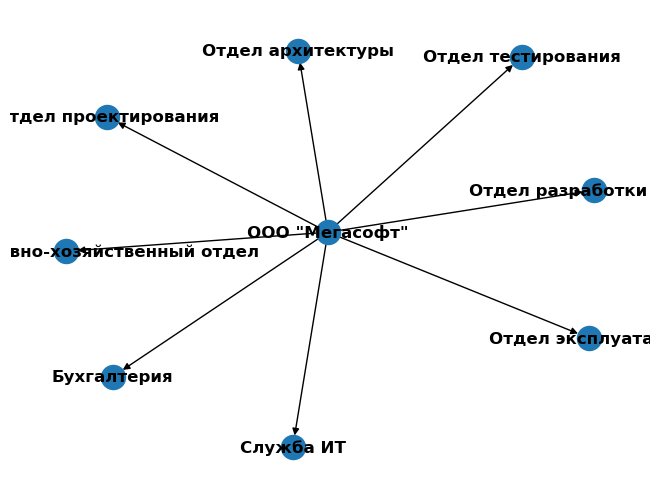

In [5]:
DG = nx.DiGraph()

DG.add_edge('ООО "Мегасофт"', departments_Unique_list[0]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[1]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[2]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[3]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[4]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[5]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[6]) 
DG.add_edge('ООО "Мегасофт"', departments_Unique_list[7]) 

nx.draw(DG, with_labels=True, font_weight='bold')